In [345]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import  expon, norm, gamma, beta, lognorm
from scipy.stats._continuous_distns import beta_gen, gamma_gen
from scipy import stats
from datetime import datetime

In [320]:
zone1 = pd.read_csv('data\out_1.csv', usecols=["Datum", "Uhrzeit", "Masse [kg]", "Geschwindigkeit [m/s]"])
zone2 = pd.read_csv('data\out_2.csv', usecols=["Date", "Uhrzeit", "m [kg]", "v [m/s]"])
zone1.columns = ["date", "time", "kg", "m/s"]
zone2.columns = ["date", "time", "kg", "m/s"]

In [321]:
pd.concat([zone1, zone2], axis=1, keys=['zone1', 'zone2']).describe()

zone1                  zone2           
                kg        m/s          kg        m/s
count    68.000000  68.000000   32.000000  32.000000
mean    628.632353   8.788235   99.250000  37.790625
std     695.884703   1.989189  104.072555   5.395778
min      12.000000   3.600000    0.000000  24.900000
25%     214.750000   7.300000   36.750000  33.200000
50%     402.500000   8.800000   58.000000  38.750000
75%     773.000000  10.125000  140.000000  41.725000
max    3104.000000  14.100000  406.000000  46.500000

In [322]:
zone1.head()

,date,time,kg,m/s
0,2019-01-01,09:00,194.0,8.4
1,2019-01-01,21:00,224.0,8.8
2,2019-01-02,14:00,3104.0,9.2
3,2019-01-04,15:00,228.0,8.0
4,2019-01-05,23:00,755.0,7.0


In [323]:
# Check for NaN values
print(zone1.isna().sum())

# Check for zeros
print(zone1.eq(0).sum())

date    11
time    11
kg      11
m/s     11
dtype: int64
date    0
time    0
kg      0
m/s     0
dtype: int64


In [324]:
zone1 = zone1.dropna(how='all')

In [325]:
zone2.head()


,date,time,kg,m/s
0,2019-01-01,09:00,38.0,45.4
1,2019-01-03,06:00,187.0,41.6
2,2019-01-04,10:00,36.0,44.6
3,2019-01-07,14:00,6.0,41.2
4,2019-01-11,06:00,65.0,39.6


In [326]:
# Check for NaN values
print(zone2.isna().sum())

# Check for zeros
print(zone2.eq(0).sum())

date    3
time    3
kg      3
m/s     3
dtype: int64
date    0
time    0
kg      1
m/s     0
dtype: int64


In [327]:
zone2 = zone2.dropna(how='all')

# Set the value to the median in the row where 'kg' equals 0.0
zone2.loc[zone2['kg'] == 0.0, 'kg'] = zone2['kg'].median()


In [328]:
pd.concat([zone1, zone2], axis=1, keys=['zone1', 'zone2']).describe()

zone1                  zone2           
                kg        m/s          kg        m/s
count    68.000000  68.000000   32.000000  32.000000
mean    628.632353   8.788235  101.062500  37.790625
std     695.884703   1.989189  102.785382   5.395778
min      12.000000   3.600000    3.000000  24.900000
25%     214.750000   7.300000   37.750000  33.200000
50%     402.500000   8.800000   58.000000  38.750000
75%     773.000000  10.125000  140.000000  41.725000
max    3104.000000  14.100000  406.000000  46.500000

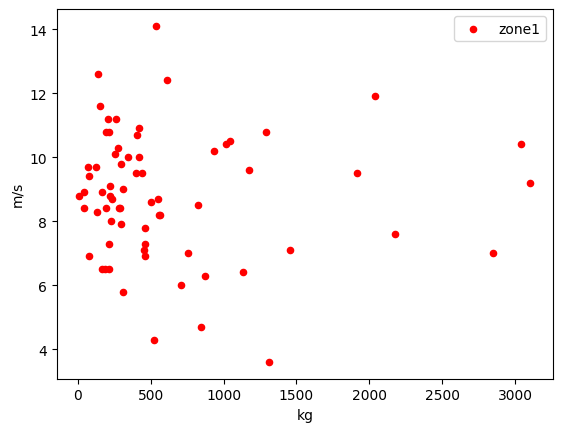

In [329]:
zone1.plot(x='kg', y='m/s', kind='scatter', c='red', label='zone1')
plt.show()

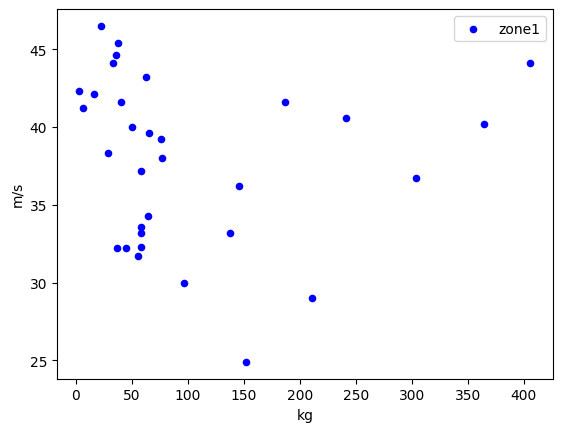

In [330]:
zone2.plot(x='kg', y='m/s', kind='scatter', c='blue', label='zone1')
plt.show()

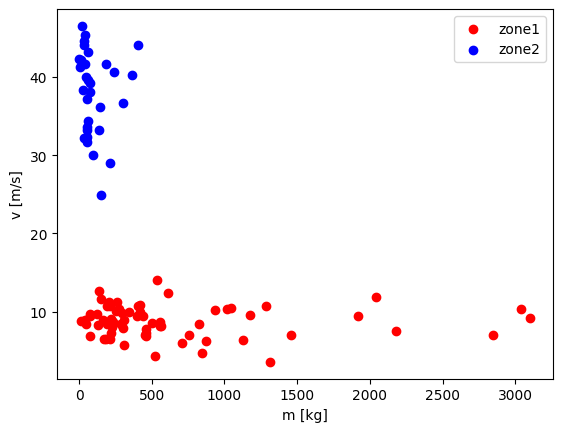

In [331]:
fig, ax = plt.subplots()
ax.scatter(zone1['kg'], zone1['m/s'], c='red', label='zone1')
ax.scatter(zone2['kg'], zone2['m/s'], c='blue', label='zone2')
ax.legend()
ax.axes.set_xlabel('m [kg]')
ax.axes.set_ylabel('v [m/s]')
plt.show()

Zonen 1 und 2 sollten nicht gemischt werden, weil sonst sehr schwere steine generiert werden könnten die eine hohe Geschwindigkeit haben, was in den Aufzeichnungen aber nicht vorkomt.

In [332]:
zone1['kj'] = 0.5 * zone1['kg'] * (zone1['m/s']**2) /1000
zone2['kj'] = 0.5 * zone2['kg'] * (zone2['m/s']**2) /1000

In [333]:
# Convert the 'date' and 'time' columns to datetime
zone1['datetime'] = pd.to_datetime(zone1['date'] + ' ' + zone1['time'])

# Calculate the time difference between each row and the row above, in hours
zone1['timediv h'] = (zone1['datetime'] - zone1['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
zone1['timediv h'] = zone1['timediv h'].apply(lambda x: int(round(x.total_seconds() / 3600)))

# Print the updated dataframe
print(zone1)

          date   time      kg  m/s          kj            datetime  timediv h
0   2019-01-01  09:00   194.0  8.4    6.844320 2019-01-01 09:00:00          0
1   2019-01-01  21:00   224.0  8.8    8.673280 2019-01-01 21:00:00         12
2   2019-01-02  14:00  3104.0  9.2  131.361280 2019-01-02 14:00:00         17
3   2019-01-04  15:00   228.0  8.0    7.296000 2019-01-04 15:00:00         49
4   2019-01-05  23:00   755.0  7.0   18.497500 2019-01-05 23:00:00         32
..         ...    ...     ...  ...         ...                 ...        ...
63  2019-03-18  16:00   167.0  8.9    6.614035 2019-03-18 16:00:00         28
64  2019-03-22  18:00  2847.0  7.0   69.751500 2019-03-22 18:00:00         98
65  2019-03-26  00:00    44.0  8.9    1.742620 2019-03-26 00:00:00         78
66  2019-03-26  06:00    45.0  8.4    1.587600 2019-03-26 06:00:00          6
67  2019-03-27  16:00   312.0  5.8    5.247840 2019-03-27 16:00:00         34

[68 rows x 7 columns]


In [334]:
# Convert the 'date' and 'time' columns to datetime
zone2['datetime'] = pd.to_datetime(zone2['date'] + ' ' + zone2['time'])

# Calculate the time difference between each row and the row above, in hours
zone2['timediv h'] = (zone2['datetime'] - zone2['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
zone2['timediv h'] = zone2['timediv h'].apply(lambda x: int(round(x.total_seconds() / 3600)))

# Print the updated dataframe
print(zone2)

          date   time     kg   m/s          kj            datetime  timediv h
0   2019-01-01  09:00   38.0  45.4   39.162040 2019-01-01 09:00:00          0
1   2019-01-03  06:00  187.0  41.6  161.807360 2019-01-03 06:00:00         45
2   2019-01-04  10:00   36.0  44.6   35.804880 2019-01-04 10:00:00         28
3   2019-01-07  14:00    6.0  41.2    5.092320 2019-01-07 14:00:00         76
4   2019-01-11  06:00   65.0  39.6   50.965200 2019-01-11 06:00:00         88
5   2019-01-11  16:00   58.0  33.2   31.964960 2019-01-11 16:00:00         10
6   2019-01-14  11:00  365.0  40.2  294.927300 2019-01-14 11:00:00         67
7   2019-01-16  02:00   22.0  46.5   23.784750 2019-01-16 02:00:00         39
8   2019-01-18  06:00  146.0  36.2   95.662120 2019-01-18 06:00:00         52
9   2019-01-19  17:00   29.0  38.3   21.269905 2019-01-19 17:00:00         35
10  2019-01-20  22:00   40.0  41.6   34.611200 2019-01-20 22:00:00         29
11  2019-01-21  11:00  304.0  36.7  204.727280 2019-01-21 11:00:

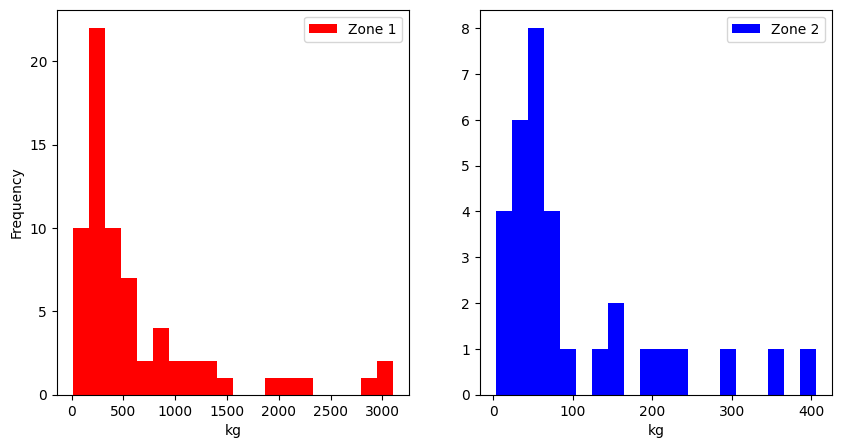

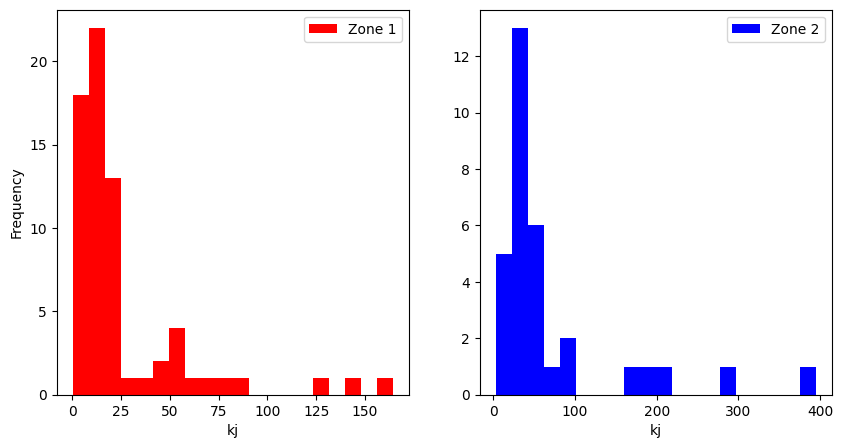

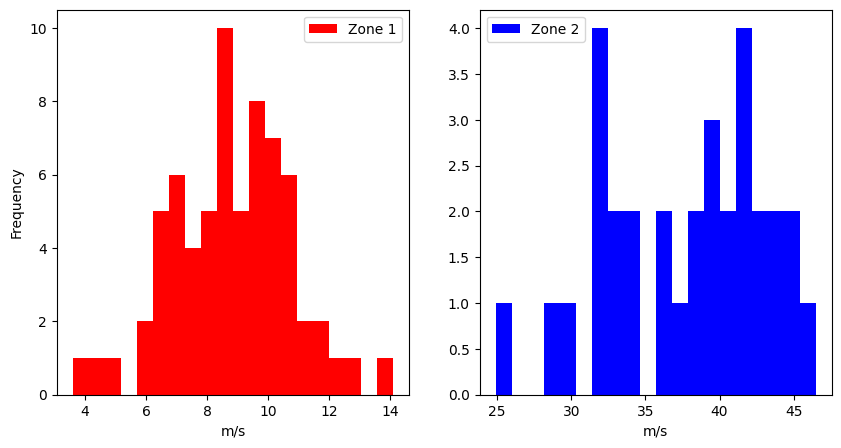

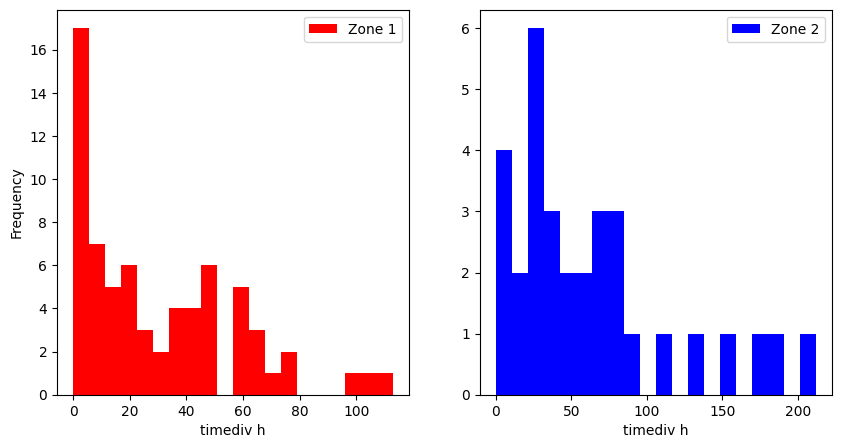

In [335]:
# Plot the histograms for 'kg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['kg'], bins=20, color='red', label='Zone 1')
ax2.hist(zone2['kg'], bins=20, color='blue', label='Zone 2')

ax1.set_xlabel('kg')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kg')
ax2.legend()
plt.show()

# Plot the histograms for 'kj'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['kj'], bins=20, color='red', label='Zone 1')
ax2.hist(zone2['kj'], bins=20, color='blue', label='Zone 2')

ax1.set_xlabel('kj')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kj')
ax2.legend()
plt.show()

# Plot the histograms for 'm/s'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['m/s'], bins=20, color='red', label='Zone 1')
ax2.hist(zone2['m/s'], bins=20, color='blue', label='Zone 2')

ax1.set_xlabel('m/s')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('m/s')
ax2.legend()
plt.show()

# Plot the histograms for 'timediv h'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['timediv h'], bins=20, color='red', label='Zone 1')
ax2.hist(zone2['timediv h'], bins=20, color='blue', label='Zone 2')

ax1.set_xlabel('timediv h')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('timediv h')
ax2.legend()
plt.show()

In [336]:
pd.concat([zone1, zone2], axis=1, keys=['zone1', 'zone2']).describe()

zone1                                          zone2             \
                kg        m/s          kj   timediv h          kg        m/s   
count    68.000000  68.000000   68.000000   68.000000   32.000000  32.000000   
mean    628.632353   8.788235   25.197761   30.102941  101.062500  37.790625   
std     695.884703   1.989189   32.704933   27.789260  102.785382   5.395778   
min      12.000000   3.600000    0.464640    0.000000    3.000000  24.900000   
25%     214.750000   7.300000    8.214900    5.750000   37.750000  33.200000   
50%     402.500000   8.800000   12.815133   22.000000   58.000000  38.750000   
75%     773.000000  10.125000   23.135955   49.000000  140.000000  41.725000   
max    3104.000000  14.100000  164.403200  113.000000  406.000000  46.500000   

                               
               kj   timediv h  
count   32.000000   32.000000  
mean    72.543707   64.250000  
std     87.452601   55.533193  
min      2.683935    0.000000  
25%     29.600176   27.750000  
50%     39.581020   48.500000  
75%     63.103560   77.250000  
max    394.796430  212.000000

In [337]:
def fit_best_distribution(data):
    # Define candidate distributions
    dist_names = [norm, lognorm, expon, gamma, beta]

    # Set up initial best parameters and likelihoods
    best_dist = None
    best_params = {}
    best_ll = np.inf

    # Set up a dictionary to store the log-likelihoods of each distribution
    ll_dict = {}

    # Iterate through candidate distributions and find the best fit
    for dist_name in dist_names:
        # Get the distribution object from scipy.stats
        #dist = getattr(scipy.stats, dist_name)

        # Fit the distribution to the data using MLE
        params = dist_name.fit(data)

        # Get the negative log-likelihood of the data under the distribution
        ll = -dist_name.logpdf(data, *params).sum()

        # If the fit is better than the current best, update the best fit
        if ll < best_ll:
            best_dist = dist_name
            best_params = params
            best_ll = ll

        # Store the log-likelihood of the fit for this distribution
        ll_dict[dist_name] = ll

    # Sort the distributions by the log-likelihood of their fit
    sorted_dists = sorted(ll_dict, key=ll_dict.get)

    # Generate a list of strings describing the fit of each distribution
    dist_strings = []
    for dist_name in sorted_dists:
        if dist_name == best_dist:
            dist_strings.append(f'{dist_name} (best fit): {ll_dict[dist_name]}')
        else:
            dist_strings.append(f'{dist_name}: {ll_dict[dist_name]}')

    # Return the list of distribution fit strings
    return dist_strings

In [338]:
fit_best_distribution(zone1['kg'])


c:\Users\bwuermli\.virtualenvs\steinschlag-t3PavukW\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


['<scipy.stats._continuous_distns.beta_gen object at 0x00000235A9D41FC0> (best fit): 499.3901307039264',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x00000235A9D72140>: 499.5812348983543',
 '<scipy.stats._continuous_distns.expon_gen object at 0x00000235A9D439D0>: 504.85056291042986',
 '<scipy.stats._continuous_distns.norm_gen object at 0x00000235A9D41A50>: 541.0566186379025',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x00000235A9D95510>: 588.3569472194833']

In [339]:
fit_best_distribution(zone2['kg']) 

['<scipy.stats._continuous_distns.beta_gen object at 0x00000235A9D41FC0> (best fit): 165.71971224753088',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x00000235A9D72140>: 176.68199068732446',
 '<scipy.stats._continuous_distns.expon_gen object at 0x00000235A9D439D0>: 178.73936097578405',
 '<scipy.stats._continuous_distns.norm_gen object at 0x00000235A9D41A50>: 193.14263439814778',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x00000235A9D95510>: 202.06737324513256']

In [340]:
fit_best_distribution(zone1['m/s'])

c:\Users\bwuermli\.virtualenvs\steinschlag-t3PavukW\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


['<scipy.stats._continuous_distns.beta_gen object at 0x00000235A9D41FC0> (best fit): 142.69904585100392',
 '<scipy.stats._continuous_distns.norm_gen object at 0x00000235A9D41A50>: 142.74955808496244',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x00000235A9D95510>: 142.78018376991054',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x00000235A9D72140>: 142.86369403078356',
 '<scipy.stats._continuous_distns.expon_gen object at 0x00000235A9D439D0>: 179.954766089044']

In [341]:
fit_best_distribution(zone2['m/s'])

['<scipy.stats._continuous_distns.beta_gen object at 0x00000235A9D41FC0> (best fit): 96.31472557940404',
 '<scipy.stats._continuous_distns.norm_gen object at 0x00000235A9D41A50>: 98.83779420429414',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x00000235A9D95510>: 98.8778261365616',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x00000235A9D72140>: 99.08821513055173',
 '<scipy.stats._continuous_distns.expon_gen object at 0x00000235A9D439D0>: 113.8080096952003']

In [342]:
fit_best_distribution(zone1['timediv h'])

['<scipy.stats._continuous_distns.beta_gen object at 0x00000235A9D41FC0> (best fit): 230.94813671087834',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x00000235A9D72140>: 236.6973062597185',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x00000235A9D95510>: 291.30271716803963',
 '<scipy.stats._continuous_distns.expon_gen object at 0x00000235A9D439D0>: 299.51435587299244',
 '<scipy.stats._continuous_distns.norm_gen object at 0x00000235A9D41A50>: 322.06028138695456']

In [343]:
fit_best_distribution(zone1['timediv h'])

['<scipy.stats._continuous_distns.beta_gen object at 0x00000235A9D41FC0> (best fit): 230.94813671087834',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x00000235A9D72140>: 236.6973062597185',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x00000235A9D95510>: 291.30271716803963',
 '<scipy.stats._continuous_distns.expon_gen object at 0x00000235A9D439D0>: 299.51435587299244',
 '<scipy.stats._continuous_distns.norm_gen object at 0x00000235A9D41A50>: 322.06028138695456']

In [344]:
# to simulate a dataframe for the next 100 years i will estimate the number of events it takes and generate a frame 



def generate_simulated_data(zone_df, num_years=100):
    
    timediv_mean = zone_df['timediv h'].mean()
    
    # Calculate  the deviation
    timediv_shape, timediv_loc, timediv_scale = gamma_gen.fit(zone_df['timediv h'], floc=0, fscale=1)
    kg_shape, kg_loc, kg_scale = beta_gen.fit(zone_df['kg'], floc=0, fscale=1)
    ms_mean, ms_std = zone_df['m/s'].mean(), zone_df['m/s'].std()

    # Calculate number of observations for 100 years
    total_hours = num_years * 365.25 * 24
    num_observations = int(total_hours / timediv_mean)
    
    # Set the starting datetime to January 1st, 2000, 00:00:00
    current_datetime = datetime(2000, 1, 1, 0, 0, 0)

    # Initialize the new dataframe and generate the data
    simulated_df = pd.DataFrame(index=range(num_observations))
    simulated_df['timediv h'] = beta_gen(timediv_shape, timediv_loc, timediv_scale).rvs(size=num_observations)
    simulated_df['m/s'] = norm(ms_mean, ms_std).rvs(size=num_observations)
    simulated_df['kg'] = beta_gen(kg_shape, kg_loc, kg_scale).rvs(size=num_observations)

    # Generate the simulated data
    
    return simulated_df


# Generate simulated dataframes
simulated1 = generate_simulated_data(zone1, 1)
simulated2 = generate_simulated_data(zone2, 1)
simulated1

TypeError: gamma_gen.fit() missing 1 required positional argument: 'data'

In [ ]:
simulated2 = generate_simulated_data(zone2, 1)


In [ ]:
simulated1.head()

In [ ]:

# Initialize an empty dataframe with 100 rows
df = pd.DataFrame(index=range(100))

# Print the resulting dataframe
print(df)